In [1]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
df = pd.DataFrame()
df['filename'] = pd.Series(os.listdir('../data/Crema'))
df['category'] = df['filename'].str.extract(r'\d+_[A-Z]{3}_([A-Z]{3})_[A-Z]+.wav')
df = df.dropna()
categories = sorted(df.category.unique())
num_map = range(len(categories))
df['category_num'] = df['category'].replace(dict(zip(categories, num_map)))

df.to_csv('../data/recording_paths.csv', index=False)

recordings = pd.read_csv('../data/recording_paths.csv')
recordings.head()

/tmp/ipykernel_97874/1654691888.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category_num'] = df['category'].replace(dict(zip(categories, num_map)))


,filename,category,category_num
0,1054_IEO_DIS_LO.wav,DIS,1
1,1001_TSI_ANG_XX.wav,ANG,0
2,1019_IOM_DIS_XX.wav,DIS,1
3,1068_WSI_DIS_XX.wav,DIS,1
4,1025_ITS_DIS_XX.wav,DIS,1


In [4]:
categories

['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

In [5]:
recordings.iloc[0].filename

'1054_IEO_DIS_LO.wav'

In [6]:
class EmotionDataset(Dataset):
    def __init__(self, data_path, data_dir, final_sample_rate, num_samples_limit, transformation, device):
        
        self.data_path = data_path
        
        self.data_dir = data_dir
        if self.data_dir[-1] != '/':
            self.data_dir += '/'
        
        self.final_sample_rate = final_sample_rate
        self.num_samples_limit = num_samples_limit
        self.device = device
        self.transformation = transformation.to(self.device)
        self.df = pd.read_csv(data_path)
        
    def __len__(self):
        return df.shape[0]
    
    def __getitem__(self, index):
        audio_path = self.get_audio_path(index)
        label = self.get_label(index)
        signal, sr = torchaudio.load(audio_path)
        
        signal = signal.to(self.device)
        signal = self.to_mono_if_necessary(signal)
        signal = self.resample_if_necessary(signal, sr)
        signal = self.cut_down_if_necessary(signal)
        signal = self.right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        
        return signal, label
    
    def resample_if_necessary(self, signal, original_sr):
        if original_sr != self.final_sample_rate:
            resampler = torchaudio.transforms.Resample(original_sr, self.final_sample_rate)
            signal = resampler(signal)
        
        return signal
    
    def to_mono_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def cut_down_if_necessary(self, signal):
        return signal[:, :self.num_samples_limit]
    
    def right_pad_if_necessary(self, signal):
        if signal.shape[1] < self.num_samples_limit:
            num_missing_samples = self.num_samples_limit - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
        
    def get_audio_path(self, index):
        return self.data_dir + self.df.iloc[index].filename
    
    def get_label(self, index):
        return self.df.iloc[index].category_num
    
    def plot_spectrogram(self, index, log=False):
        spec = self.__getitem__(index)[0]
        spec = spec.cpu().numpy().reshape(spec.shape[1], -1)
        frame_rate = self.final_sample_rate / self.transformation.hop_length
        seconds = np.arange(spec.shape[1]) / frame_rate
        
        if log:
            spec[spec == 0] = 0.000000001
            spec = np.log(spec)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(spec, cmap='inferno', origin='lower', aspect='auto')
        plt.xlabel('Time (s)')
        plt.ylabel('Mel')
        plt.colorbar(label='Intensity (dB)')
        plt.xticks(np.linspace(0, spec.shape[1], 12)[:-1], np.linspace(0, seconds[-1], 12).round(2)[:-1])
        plt.show()

In [7]:
RECORDING_DF_PATH = os.path.join('..', 'data', 'recording_paths.csv')
DATA_DIR = os.path.join('..', 'data', 'Crema')
FINAL_SR = 16000
NUM_SAMPLES_LIMIT = 60000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=FINAL_SR,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


emd = EmotionDataset(RECORDING_DF_PATH, DATA_DIR, FINAL_SR, NUM_SAMPLES_LIMIT, mel_spectrogram, device)

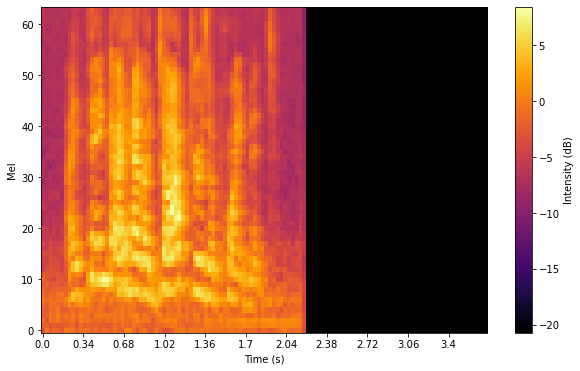

In [8]:
emd.plot_spectrogram(300, log=True)

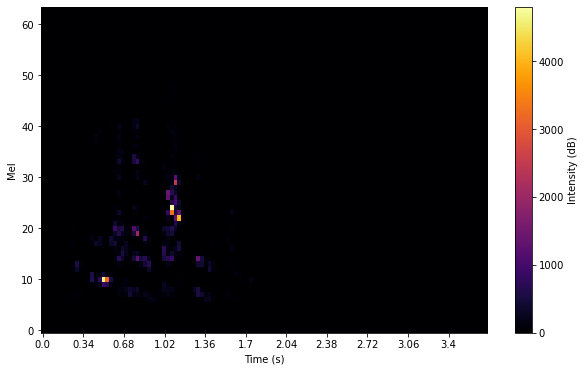

In [9]:
emd.plot_spectrogram(300, log=False)

In [10]:
class CNNNetwork(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        in_kernels = 1
        out_kernels = 16
        for i in range(self.num_layers):
            conv = nn.Sequential(
                nn.Conv2d(in_channels=in_kernels, out_channels=out_kernels, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            )
            self.layers.append(conv)
            
            in_kernels = out_kernels
            out_kernels *= 2
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5760, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_data):
        out = self.layers[0](input_data)
        
        for layer in self.layers[1:]:
            out = layer(out)
        
        out = self.flatten(out)
        out = self.linear(out)
        predictions = self.softmax(out)
        
        return predictions

In [11]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001

def create_data_loader(train_data, batch_size):
    data_loader = DataLoader(train_data, batch_size = batch_size)
    return data_loader

def train_single_epoch(model, data_loader, loss, optimizer, device):
    for inp, target in data_loader:
        inp, target = inp.to(device), target.to(device)
        
        pred = model(inp)
        loss = loss_fn(pred, target)

        optimiser.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Loss = {loss.item()}')

def train(model, data_loader, loss, optimizer, device, num_epochs):
    print('Started training\n')
    for i in range(1, num_epochs+1):
        print(f'Epoch {i} / {num_epochs} started')
        train_single_epoch(model, data_loader, loss, optimizer, device)
        print(f'Epoch {i} / {num_epochs} finished')
        print()

In [12]:
train_dataloader = create_data_loader(emd, BATCH_SIZE)

cnn = CNNNetwork(num_layers=4).to(device)
print(summary(cnn, (1, 64, 118)))
print()

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                             lr=LEARNING_RATE)

train(cnn.cuda(), train_dataloader, loss_fn, optimiser, device, EPOCHS)

torch.save(cnn.state_dict(), "cnn.pth")
print("Trained cnn saved at cnn.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 120]             160
              ReLU-2          [-1, 16, 66, 120]               0
         MaxPool2d-3           [-1, 16, 33, 60]               0
            Conv2d-4           [-1, 32, 35, 62]           4,640
              ReLU-5           [-1, 32, 35, 62]               0
         MaxPool2d-6           [-1, 32, 17, 31]               0
            Conv2d-7           [-1, 64, 19, 33]          18,496
              ReLU-8           [-1, 64, 19, 33]               0
         MaxPool2d-9            [-1, 64, 9, 16]               0
           Conv2d-10          [-1, 128, 11, 18]          73,856
             ReLU-11          [-1, 128, 11, 18]               0
        MaxPool2d-12            [-1, 128, 5, 9]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [13]:
def predict(model, inp, target, class_mapping):
    model.eval()
    
    with torch.no_grad():
        prediction_probs = model(inp)
        predicted_index = prediction_probs[0].argmax()
        prediction = class_mapping[predicted_index]
        expected = class_mapping[target]
    
    return prediction, expected

In [14]:
class_mapping = categories
state_dict = torch.load("cnn.pth")
cnn.load_state_dict(state_dict)

idx = 1

inp, target = emd[idx][0], emd[idx][1]
inp.unsqueeze_(0)

predicted, expected = predict(cnn, inp, target,class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'FEA', expected: 'ANG'


In [15]:
train_df = pd.read_csv('../data/recording_paths.csv')
expected = train_df.category

predictions = []
for i in range(len(emd)):
    inp, target = emd[i][0], emd[i][1]
    inp.unsqueeze_(0)
    predictions.append(predict(cnn, inp, target, class_mapping)[0])
    
    if i % 1000 == 0:
        print(f'{i} / {len(emd)} Done')

0 / 7442 Done
1000 / 7442 Done
2000 / 7442 Done
3000 / 7442 Done
4000 / 7442 Done
5000 / 7442 Done
6000 / 7442 Done
7000 / 7442 Done


In [16]:
confusion_matrix(expected, np.array(predictions))

array([[   0,    0, 1170,    0,    0,  101],
       [   0,    0,  553,    0,    0,  718],
       [   0,    0,  703,    0,    0,  568],
       [   0,    0, 1051,    0,    0,  220],
       [   0,    0,  522,    0,    0,  565],
       [   0,    0,  188,    0,    0, 1083]])

In [17]:
from sklearn.metrics import classification_report

print(classification_report(expected, np.array(predictions)))

              precision    recall  f1-score   support

         ANG       0.00      0.00      0.00      1271
         DIS       0.00      0.00      0.00      1271
         FEA       0.17      0.55      0.26      1271
         HAP       0.00      0.00      0.00      1271
         NEU       0.00      0.00      0.00      1087
         SAD       0.33      0.85      0.48      1271

    accuracy                           0.24      7442
   macro avg       0.08      0.23      0.12      7442
weighted avg       0.09      0.24      0.13      7442



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
